# Editing graph state

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!

## Goals

Now, let's show how to directly edit the graph state and insert human feedback.

In [1]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## Editing state 

Previously, we introduced breakpoints.

We used them to interrupt the graph and await user approval before executing the next node.

But breakpoints are also [opportunities to modify the graph state](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/).

Let's set up our agent with a breakpoint before the `assistant` node.

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b


tools = [add, multiply, divide, subtract]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [4]:
# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

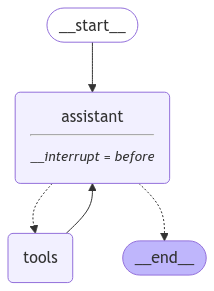

In [5]:
# new graph with interupts
builder = StateGraph(MessagesState)
# define the nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
# define the edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
# add feedback loop
builder.add_edge("tools", "assistant")

# compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["assistant"])

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Input
initial_input = {"messages": "Multiply 2 and 3 and then add 4."}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3 and then add 4.


In [7]:
# check the state
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3 and then add 4.', additional_kwargs={}, response_metadata={}, id='805b3fae-7a94-4f69-bdb7-d8711de05a55')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe76ff-0f9d-69ed-8000-af1218a0ee15'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-02-10T05:29:04.206678+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe76ff-0f96-6f44-bfff-624ce81a458a'}}, tasks=(PregelTask(id='5f6e19e9-a177-a1ad-252d-3a4ce4c1920d', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [8]:
id = state.values["messages"][0].id
print(id)

805b3fae-7a94-4f69-bdb7-d8711de05a55


Now, we can directly apply a state update.

Remember, updates to the `messages` key will use the `add_messages` reducer:
 
* If we want to over-write the existing message, we can supply the message `id`.
* If we simply want to append to our list of messages, then we can pass a message without an `id` specified, as shown below.

In [9]:
# update state
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe76ff-2036-6e10-8001-d3cc4d3fd475'}}

In [10]:
# check the state
state = graph.get_state(thread)
state.values

{'messages': [HumanMessage(content='Multiply 2 and 3 and then add 4.', additional_kwargs={}, response_metadata={}, id='805b3fae-7a94-4f69-bdb7-d8711de05a55'),
  HumanMessage(content='No, actually multiply 3 and 3!', additional_kwargs={}, response_metadata={}, id='55abf125-d57e-4a88-a619-9ab3fe704b4d')]}

Let's have a look.

We called `update_state` with a new message. 

The `add_messages` reducer appends it to our state key, `messages`.

In [11]:
new_state = graph.get_state(thread).values
for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3 and then add 4.
================================ Human Message =================================

No, actually multiply 3 and 3!


Now, let's proceed with our agent, simply by passing `None` and allowing it proceed from the current state.

We emit the current and then proceed to execute the remaining nodes i.e we proceed with the latest state.

In [12]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_oOcncZwWtXiiVaRlr6zGSkB3)
 Call ID: call_oOcncZwWtXiiVaRlr6zGSkB3
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [13]:
# Now, we're back at the `assistant`, which has our `breakpoint`.

# We can again pass `None` to proceed.
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9


================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


We can do the same by updating the last state by the id

In [14]:
# Input
initial_input = {"messages": "Multiply 2 and 3 and then add 4."}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3 and then add 4.


In [15]:
# check the state
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3 and then add 4.', additional_kwargs={}, response_metadata={}, id='65ee8332-fded-45cf-85b5-e3c3c84f9d92')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efe76ff-5560-6b74-8000-4c7074985fba'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '2', 'step': 0, 'parents': {}}, created_at='2025-02-10T05:29:11.521763+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efe76ff-555b-6549-bfff-6afd1599dd17'}}, tasks=(PregelTask(id='c3ddb59c-2d19-62a8-034a-c1fd0e26abba', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [16]:
id = state.values["messages"][0].id
print(id)

65ee8332-fded-45cf-85b5-e3c3c84f9d92


In [17]:
# update state
graph.update_state(
    thread,
    {
        "messages": [
            HumanMessage(content="No, actually multiply 3 and 3 and then add 4!", id=id)
        ]
    },
)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe76ff-6133-6c24-8001-426bb673b00e'}}

In [18]:
# one message only
new_state = graph.get_state(thread).values
for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3 and then add 4!


In [19]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3 and then add 4!


================================== Ai Message ==================================
Tool Calls:
  multiply (call_QGhfGUafxWvVSwtWbuodo7VK)
 Call ID: call_QGhfGUafxWvVSwtWbuodo7VK
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [20]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9


================================== Ai Message ==================================
Tool Calls:
  add (call_1nTL07hXOp1bCJgb1z3vg3hj)
 Call ID: call_1nTL07hXOp1bCJgb1z3vg3hj
  Args:
    a: 9
    b: 4
================================= Tool Message =================================
Name: add

13


In [21]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

The result of multiplying 3 and 3 and then adding 4 is 13.


In [22]:
# get the final state and we continue till we reach the end
state = graph.get_state(thread)
state.next

()

## Awaiting user input

So, it's clear that we can edit our agent state after a breakpoint.

Now, what if we want to allow for human feedback to perform this state update?

We'll add a node that [serves as a placeholder for human feedback](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup) within our agent.

`This human_feedback node allow the user to add feedback directly to state.`
 
We specify the breakpoint using `interrupt_before` our `human_feedback` node.

We set up a checkpointer to save the state of the graph up until this node.

We use the same list of tools but introduce a new node human_feedback that will be used to handle the human feedback. This node will be used to update the state of the graph with the human feedback.

In [24]:
# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)

# Node
def human_feedback(state: MessagesState):
    pass


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

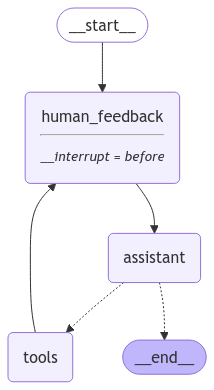

In [30]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
from uuid import uuid4

# Input
initial_input = {"messages": "Multiply 2 and 3 and then add 4."}

# Thread
thread = {"configurable": {"thread_id": str(uuid4())}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3 and then add 4.


In [36]:
# get the state
state = graph.get_state(thread)
state.next

('human_feedback',)

In [37]:
# We now update the state as if we are the human_feedback node
user_input = HumanMessage(content="No, actually multiply 3 and 3 and then add 4!")
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3 and then add 4!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QiZok7ImYjOWt8xyZLdgBce9)
 Call ID: call_QiZok7ImYjOWt8xyZLdgBce9
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [38]:
# get the state
state = graph.get_state(thread)
state.next

('human_feedback',)

In [39]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================
Tool Calls:
  add (call_N29wA5OoGZLvuov9XT1R0RFn)
 Call ID: call_N29wA5OoGZLvuov9XT1R0RFn
  Args:
    a: 9
    b: 4
================================= Tool Message =================================
Name: add

13


In [40]:
# get the state
state = graph.get_state(thread)
state.next

('human_feedback',)

In [41]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

Multiplying 3 and 3 gives 9, and adding 4 results in 13.


In [42]:
# get the state
state = graph.get_state(thread)
state.next

()

In [44]:
from uuid import uuid4

# Initial input message
initial_input = {"messages": "Multiply 2 and 3 and then add 4."}

# Create a new thread with a unique thread_id
thread = {"configurable": {"thread_id": str(uuid4())}}

# For the first iteration we send the initial input.
current_input = initial_input

while True:
    # Stream the current input through the graph.
    for event in graph.stream(current_input, thread, stream_mode="values"):
        # Print the most recent message from the event.
        event["messages"][-1].pretty_print()

    # Retrieve the current state of the graph.
    state = graph.get_state(thread)
    print("Current state.next:", state.next)  # For debugging/inspection

    # Check if the graph execution is complete.
    if state.next == ():
        break

    # If the state expects human feedback, prompt the user for updated input.
    if "human_feedback" in state.next:
        user_feedback = input("Please provide human feedback: ")
        # Create a HumanMessage from the user's feedback.
        updated_message = HumanMessage(content=user_feedback)
        # Update the state as if the human_feedback node has provided the new input.
        graph.update_state(
            thread, {"messages": updated_message}, as_node="human_feedback"
        )
    else:
        # If the next expected node is not human feedback (e.g. a tool call),
        # you might choose to automatically continue (or add additional logic here).
        pass

    # For subsequent iterations the input is None because we are just processing pending updates.
    current_input = None

print("Graph execution completed.")

================================ Human Message =================================

Multiply 2 and 3 and then add 4.
Current state.next: ('human_feedback',)
================================ Human Message =================================

lets do one thing multiply 3 and 3 and then add 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_VU1qpmatHo7tkDprqeWIwl70)
 Call ID: call_VU1qpmatHo7tkDprqeWIwl70
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9
Current state.next: ('human_feedback',)
================================ Human Message =================================

no change
================================== Ai Message ==================================
Tool Calls:
  add (call_hkgpeuEqfZw2GRK3WhgdyBHs)
 Call ID: call_hkgpeuEqfZw2GRK3WhgdyBHs
  Args:
    a: 9
    b: 4
================================= Tool Message =================================
Na